# Imports and Definitions

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

forecast_dir = './data/forecast/'

In [2]:
# Fields in historical dataset from rp5
h = {'T': 'Температура воздуха (градусы Цельсия) на высоте 2 метра над поверхностью земли',
    'Po': 'Атмосферное давление на уровне станции (миллиметры ртутного столба)',
    'P': 'Атмосферное давление, приведенное к среднему уровню моря (миллиметры ртутного столба)',
    'Pa': 'Барическая тенденция: изменение атмосферного давления за последние три часа (миллиметры ртутного столба)',
    'U': 'Относительная влажность (%) на высоте 2 метра над поверхностью земли',
    'DD': 'Направление ветра (румбы) на высоте 10-12 метров над земной поверхностью, осредненное за 10-минутный период, непосредственно предшествовавший сроку наблюдения',
    'Ff': 'Cкорость ветра на высоте 10-12 метров над земной поверхностью, осредненная за 10-минутный период, непосредственно предшествовавший сроку наблюдения (метры в секунду)',
    'ff10': 'Максимальное значение порыва ветра на высоте 10-12 метров над земной поверхностью за 10-минутный период, непосредственно предшествующий сроку наблюдения (метры в секунду)',
    'ff3': 'Максимальное значение порыва ветра на высоте 10-12 метров над земной поверхностью за период между сроками (метры в секунду)',
    'N': 'Общая облачность',
    'WW': 'Текущая погода, сообщаемая с метеорологической станции',
    'W1': 'Прошедшая погода между сроками наблюдения 1',
    'W2': 'Прошедшая погода между сроками наблюдения 2',
    'Tn': 'Минимальная температура воздуха (градусы Цельсия) за прошедший период (не более 12 часов)',
    'Tx': 'Максимальная температура воздуха (градусы Цельсия) за прошедший период (не более 12 часов)',
    'Cl': 'Слоисто-кучевые, слоистые, кучевые и кучево-дождевые облака',
    'Nh': 'Количество всех наблюдающихся облаков Cl или, при отсутствии облаков Cl, количество всех наблюдающихся облаков Cm',
    'H': 'Высота основания самых низких облаков (м)',
    'Cm': 'Высококучевые, высокослоистые и слоисто-дождевые облака',
    'Ch': 'Перистые, перисто-кучевые и перисто-слоистые облака',
    'VV': 'Горизонтальная дальность видимости (км)',
    'Td': 'Температура точки росы на высоте 2 метра над поверхностью земли (градусы Цельсия)',
    'RRR': 'Количество выпавших осадков (миллиметры)',
    'tR': 'Период времени, за который накоплено указанное количество осадков (часы)',
    'E': 'Состояние поверхности почвы без снега или измеримого ледяного покрова',
    'Tg': 'Минимальная температура поверхности почвы за ночь. (градусы Цельсия)',
    "E'": 'Состояние поверхности почвы со снегом или измеримым ледяным покровом',
    'sss': 'Высота снежного покрова (см)'}

In [3]:
# Fields in forecast datasets
forecast_cols = {'Request time': 'req_datetime',
                 'Update time': 'upd_datetime',
                 'Time': 'datetime',
                 'Temperature, deg. C': 'temp',
                 'Min temperature, deg. C': 'min_temp',
                 'Max temperature, deg. C': 'max_temp',
                 'Min/max temperature, deg. C': 'temp',
                 'Feels like, deg. C': 'feels_like',
                 'Humidity, pct': 'hum',
                 'Pressure, mmHg': 'press',
                 'Precipitation': 'precip_str',
                 'Precipitation, mm': 'precip',
                 'Probability of precipitation, pct': 'precip_prob',
                 'Snowfall, sm': 'snowfall',
                 'Snow depth, sm': 'snow_depth',
                 'Wind speed, m/s': 'wind_speed',
                 'Wind gusts, m/s': 'wind_gusts',
                 'Wind direction, deg': 'wind_dir_deg',
                 'Wind direction': 'wind_dir',
                 'Cloud cover': 'cloud_cover',
                 'Conditions': 'conditions',
                 'Road conditions': 'road',
                 'Fog, pct': 'fog',
                 'Visibility': 'vis',
                 'UV index': 'uv_ind',
                 'Kp-index': 'kp_ind',
                 'Birch pollen, points': 'birch',
                 'Magnetic field': 'm_field'}
wind_dir_to_deg = {'С': '0', 'СВ': '45', 'В': '90', 'ЮВ': '135',
                   'Ю': '180', 'ЮЗ': '225', 'З': '270', 'СЗ': '315'}

In [4]:
def sort_cols_rows(df):
    first_cols = ['datetime', 'req_datetime', '12h_bin']
    new_df = df.reindex(columns=first_cols + [c for c in list(df.columns) if c not in first_cols], copy=False)
    new_df.sort_values(by=['datetime', 'req_datetime'], axis=0, ascending=[1, 1], inplace=True)
    return new_df

def replace_minus_plus(df, cols):
    for c in cols:
        df[c] = df[c].str.replace('−', '-')
        df[c] = df[c].str.replace('+', '', regex=False)
        df[c] = df[c].astype(float)
        
def precip_at_8_and_20(df):
    df_0 = df[['datetime', '12h_bin', 'precip']].copy()
    # add "precip_datetime" column for aggregating precipitation data at 08:00 and 20:00
    df_0['precip_datetime'] = (df_0['datetime'] + pd.to_timedelta(4, unit="h")).dt.ceil('12H') - pd.to_timedelta(4, unit="h")
    df_0 = df_0.groupby(['12h_bin', 'precip_datetime']).aggregate({'datetime': 'max', 'precip': 'sum'}).reset_index()
    # an interval should include the end point
    df_0 = df_0.loc[(df_0['precip_datetime'] == df_0['datetime']) & (df_0['12h_bin'] > 0)]
    # the interval will be incomplete if request time is in:
    # [11:00, 12:00) or [23:00, 00:00) for Gismeteo or HMCR
    # [09:00, 12:00) or [21:00, 00:00) for rp5
    return df_0[['datetime', '12h_bin', 'precip']].sort_values(by=['datetime', '12h_bin'], axis=0, ascending=[1, 0])
        
def get_min_max_temp(df, col='temp', new_col_name='temp', which='both'):
    df_min_max = df.loc[:, ['datetime', '12h_bin', col]].copy()
    # df_min_max.reset_index(inplace=True)
    if col != new_col_name:
        df_min_max.rename(columns={col: new_col_name}, inplace=True)
    df_min_max['date'] = df_min_max['datetime'].dt.date
    min_filt = df_min_max['datetime'].dt.hour < 12
    df_min_max.drop('datetime', axis=1, inplace=True)
    if which != 'max':
        df_min = df_min_max.loc[min_filt].groupby(by=['date', '12h_bin'], axis=0).min()
        df_min.reset_index(inplace=True)
        # drop records with a request time after the beginning of the interval
        df_min = df_min.loc[df_min['12h_bin']>0]
        df_min.sort_values(by=['date', '12h_bin'], axis=0, ascending=[1, 0], inplace=True)
    if which != 'min':
        df_max = df_min_max.loc[~min_filt].groupby(by=['date', '12h_bin'], axis=0).max()
        df_max.reset_index(inplace=True)
        # drop records with a request time after the beginning of the interval
        df_max = df_max.loc[df_max['12h_bin']>0]
        df_max.sort_values(by=['date', '12h_bin'], axis=0, ascending=[1, 0], inplace=True)
    if which == 'min':
        return df_min
    elif which == 'max':
        return df_max
    else:
        return df_min, df_max

def merge_dfs(dfs, col, col_keys, how):
    keys = list(dfs.keys())
    cols = col_keys.copy()
    cols.append(col)
    key0 = keys[0]
    df0 = dfs[key0][cols].copy()
    df0.rename(columns={col: key0}, inplace=True)
    for k in keys[1:]:
        df1 = dfs[k][cols].copy()
        df1.rename(columns={col: k}, inplace=True)
        df0 = df0.merge(df1, 
                        how=how,
                        left_on=col_keys,
                        right_on=col_keys,
                        sort=False,
                        validate='one_to_one')
    return df0


def boxplot_params(df, title, ylabel, ylim, legend_labels, legend_loc='upper left', yticks=None):
    df_ = df.loc[(df['datetime'] >= start_date) & (df['datetime'] <= end_date)].copy()
    df_['Day'] = np.ceil(df_['12h_bin'] / 2).astype(int)
    pm_filt = df_['datetime'].dt.hour > 12
    df_.loc[pm_filt, 'Day'] = np.ceil((df_.loc[pm_filt, '12h_bin'] - 1) / 2).astype(int)
    df_ = df_.loc[df_['Day'] <= day_lim]
    df_ = df_.melt(id_vars=['Day'],
                   value_vars=[*legend_labels.keys()],
                   var_name='Forecast',
                   value_name=ylabel)
    ax = sns.boxplot(x='Day', y=ylabel, data=df_, hue='Forecast', palette=colors, whis=1.5, fliersize=3)
    handles, labels = ax.get_legend_handles_labels()
    ax.set(title=title)
    ax.set_ylim(*ylim)
    if yticks:
        ax.set_yticks(range(*yticks))
    ax.legend(handles, [legend_labels[k] for k in labels], ncol=len(labels), loc=legend_loc)

# Location

[Wikipedia](https://en.wikipedia.org/wiki/Artyomovsky,_Sverdlovsk_Oblast): **Artyomovsky** (Russian: Артёмовский) is a town in Sverdlovsk Oblast, Russia, located on the Bobrovka River (Irbit's tributary, Ob's basin), 120 kilometers (75 mi) northeast of Yekaterinburg. Population: 33,160 (2010 Census); 34,980 (2002 Census); 41,247 (1989 Census). The map below is provided by [Yandex.Maps](https://yandex.com/maps/geo/artyomovskiy/53156571).

![Artyomovsky_Yandex.png](./data/images/Artyomovsky_Yandex.png)

# Historical Data

A weather archive for Artyomovsky, Sverdlovsk Oblast was downloaded from [rp5.ru](https://rp5.ru/%D0%90%D1%80%D1%85%D0%B8%D0%B2_%D0%BF%D0%BE%D0%B3%D0%BE%D0%B4%D1%8B_%D0%B2_%D0%90%D1%80%D1%82%D0%B5%D0%BC%D0%BE%D0%B2%D1%81%D0%BA%D0%BE%D0%BC).

In [5]:
hist_file = './data/28346.13.04.2006.18.08.2022.1.0.0.ru.utf8.00000000.csv'
hist_cols = {'T': 'temp', 'Po': 'press', 'P': 'press_sea', 'Pa': 'press_change_3h',
     'U': 'hum', 'DD': 'wind_dir_10m', 'Ff': 'wind_speed_10m',
     'ff10': 'max_wind_speed_10m', 'ff3': 'max_wind_speed_3h', 'N': 'clouds',
    'WW': 'cur_weather', 'W1': 'weather_3h_1', 'W2': 'weather_3h_2',
    'Tn': 'min_temp_3h', 'Tx': 'max_temp_3h', 'Cl': 'Cl_clouds',
    'Nh': 'Cl_Cm_clouds','H': 'cloud_base', 'Cm': 'Cm_clouds', 'Ch': 'Ch_clouds',
    'VV': 'vis', 'Td': 'dew_point', 'RRR': 'precip', 'tR': 'precip_int',
    'E': 'earth_wo_snow', 'Tg': 'min_night_earth_temp', "E'": 'earth_w_snow',
    'sss': 'snow_level', 'Местное время в Артемовском': 'datetime'}
hist_wind_dir_to_deg = {'Ветер, дующий с севера': '0',
                        'Ветер, дующий с северо-северо-востока': '22.5',
                        'Ветер, дующий с северо-востока': '45',
                        'Ветер, дующий с востоко-северо-востока': '67.5',
                        'Ветер, дующий с востока': '90',
                        'Ветер, дующий с востоко-юго-востока': '112.5',
                        'Ветер, дующий с юго-востока': '135',
                        'Ветер, дующий с юго-юго-востока': '157.5',
                        'Ветер, дующий с юга': '180',
                        'Ветер, дующий с юго-юго-запада': '202.5',
                        'Ветер, дующий с юго-запада': '225',
                        'Ветер, дующий с западо-юго-запада': '247.5',
                        'Ветер, дующий с запада': '270',
                        'Ветер, дующий с западо-северо-запада': '292.5',
                        'Ветер, дующий с северо-запада': '315',
                        'Ветер, дующий с северо-северо-запада': '337.5',
                        'Штиль, безветрие': np.nan,
                        'Переменное направление': np.nan}
cols_to_drop = ['press_sea', 'press_change_3h', 'clouds', 
                'Cl_clouds', 'Cl_Cm_clouds', 'cloud_base', 
                'Cm_clouds', 'Ch_clouds', 'dew_point', 'earth_wo_snow', 
                'min_night_earth_temp', 'earth_w_snow']
hist = pd.read_csv(hist_file, sep=';', comment='#', 
                   parse_dates=[0], dayfirst=True, index_col=False)
hist.rename(columns=hist_cols, inplace=True)
hist.drop(columns=cols_to_drop, inplace=True)
hist.set_index('datetime', inplace=True)
hist.sort_index(level='datetime', axis=0, ascending=True, inplace=True)
# convert wind directions into numerical values (degrees)
hist['wind_dir_10m'] = hist['wind_dir_10m'].map(hist_wind_dir_to_deg).astype(float)
# convert "precip" and "snow_level" columns to float
hist['precip'].replace({'Осадков нет': '0', 'Следы осадков': '0.05'}, inplace=True)
hist['precip'] = hist['precip'].astype(float)
hist['snow_level'].replace({'Менее 0.5': '0.25', 'Снежный покров не постоянный.': np.nan}, inplace=True)
hist['snow_level'] = hist['snow_level'].astype(float)
hist.sample(4)

,temp,press,hum,wind_dir_10m,wind_speed_10m,max_wind_speed_10m,max_wind_speed_3h,cur_weather,weather_3h_1,weather_3h_2,min_temp_3h,max_temp_3h,vis,precip,precip_int,snow_level
datetime,,,,,,,,,,,,,,,,
2020-09-04 02:00:00,7.5,755.9,74.0,337.5,2.0,NaN,NaN,,NaN,NaN,NaN,NaN,10.0,NaN,NaN,NaN
2022-07-14 05:00:00,15.0,749.5,94.0,NaN,0.0,NaN,NaN,Более или менее сплошной слой приземного или л...,Облака покрывали более половины неба в течение...,Облака покрывали более половины неба в течение...,NaN,NaN,20.0,NaN,NaN,NaN
2020-04-05 08:00:00,1.1,743.8,93.0,0.0,2.0,NaN,NaN,Дождь или морось со снегом слабые.,Дождь со снегом или другими видами твердых оса...,Дождь.,1.1,NaN,10.0,4.0,12.0,NaN
2018-05-15 14:00:00,13.5,745.0,23.0,292.5,5.0,NaN,13.0,,NaN,NaN,NaN,NaN,50.0,NaN,NaN,NaN


# Gismeteo Forecast

**Gismeteo** provides [10-day forecast](https://www.gismeteo.ru/weather-artemovsky-4495/) ([EN](https://www.gismeteo.com/weather-artemovsky-4495/)) with a three hour interval (02:00, 05:00, 08:00, 11:00, 14:00, 17:00, 20:00, 23:00).

### Russian Version

![gm_main_ru.png](./data/images/gm_main_ru.png)

![gm_wind_ru.png](./data/images/gm_wind_ru.png)

![gm_pollen_ru.png](./data/images/gm_pollen_ru.png)

![gm_roads_ru.png](./data/images/gm_roads_ru.png)

![gm_pressure_ru.png](./data/images/gm_pressure_ru.png)

![gm_humidity_ru.png](./data/images/gm_humidity_ru.png)

![gm_sun_moon_ru.png](./data/images/gm_sun_moon_ru.png)

![gm_kp_ru.png](./data/images/gm_kp_ru.png)

### English Version

![gm_main_en.png](./data/images/gm_main_en.png)

![gm_wind_en.png](./data/images/gm_wind_en.png)

![gm_pollen_en.png](./data/images/gm_pollen_en.png)

![gm_pressure_en.png](./data/images/gm_pressure_en.png)

![gm_humidity_en.png](./data/images/gm_humidity_en.png)

![gm_visibility_en.png](./data/images/gm_visibility_en.png)

![gm_sun_moon_en.png](./data/images/gm_sun_moon_en.png)

![gm_kp_en.png](./data/images/gm_kp_en.png)

### Loading Data

In [6]:
gm = pd.read_csv(forecast_dir + 'gismeteo-artemovsky-4495.csv',
                 sep=';',
                 parse_dates=[0, 1, 2],
                 dtype={3: 'float', 4: 'float', 5: 'float'},
                 na_values=['н/д', '-', '—', 'Нет данных'])
gm.rename(columns=forecast_cols, inplace=True)
gm['req_datetime'].fillna(method='ffill', inplace=True)
# replace commas in some columns and convert them to float
for c in ['precip', 'snowfall', 'snow_depth']:
    gm[c] = gm[c].str.replace(',', '.').astype(float)
gm['kp_ind'] = gm['kp_ind'].astype(float)
# split wind data into speed and gusts columns
speed_gusts = gm['wind_speed'].str.split(pat='-', expand=True)
gm['wind_speed'] = speed_gusts[0].astype(float)
gm['wind_gusts'] = speed_gusts[1].astype(float)
# convert wind directions into numerical values (degrees)
gm['wind_dir'] = gm['wind_dir'].map(wind_dir_to_deg).astype(float)
# visibility column has different units
vis = gm['vis'].str.extract(r'(\d+)\ ?([км]+)')
vis[2] = vis[0].astype(float)
km_filt = vis[1] == 'км'
vis.loc[km_filt, 2] = vis.loc[km_filt, 2] * 1000
gm['vis'] = vis[2]
# Gismeteo forecast also contains actual data
# (temperature, wind speed, wind gusts, precipitations, conditions)
past_filt = gm['req_datetime'] > gm['datetime']
gm_hist = gm.loc[past_filt & gm['upd_datetime'].isna()].copy()
gm = gm.loc[~past_filt]
# "upd_datetime" column can be dropped
gm.drop('upd_datetime', axis=1, inplace=True)
gm_hist.drop(['req_datetime', 'upd_datetime'], axis=1, inplace=True)
gm_hist.drop_duplicates(subset='datetime', keep='last', inplace=True)
gm_hist.set_index('datetime', inplace=True)
# "datetime" and "req_datetime" can be split into 12-hour bins ([00:00, 12:00) and [12:00, 24:00))
# add "12h_bin" column indicating bin number: 0 if "datetime" and "req_datetime" are in the same bin,
# 1 if "datetime" is in the next bin relative to "req_datetime" and so on
gm['12h_bin'] = ((gm['datetime'].dt.floor('12H') - gm['req_datetime'].dt.floor('12H')) / pd.to_timedelta(12, unit="h")).astype(int)
# drop duplicates by keeping the last record in a bin for each "datetime"
gm.drop_duplicates(subset=['datetime', '12h_bin'], keep='last', inplace=True)
# sort columns and rows
gm = sort_cols_rows(gm)
gm.sample(4)

,datetime,req_datetime,12h_bin,temp,hum,press,precip,snowfall,snow_depth,wind_speed,wind_dir,conditions,road,vis,uv_ind,kp_ind,birch,wind_gusts
19020,2022-06-22 14:00:00,2022-06-15 05:25:28,15,16.0,81.0,741.0,0.0,NaN,NaN,6.0,0.0,Пасмурно,Сухая дорога,NaN,NaN,3.0,0.0,9.0
23172,2022-07-17 14:00:00,2022-07-11 05:25:28,13,24.0,62.0,745.0,0.5,NaN,NaN,2.0,0.0,"Пасмурно, небольшой дождь",Влажная дорога,NaN,NaN,3.0,0.0,3.0
15240,2022-05-28 02:00:00,2022-05-23 05:29:34,10,10.0,87.0,742.0,0.0,NaN,NaN,4.0,180.0,Облачно,Сухая дорога,NaN,NaN,4.0,1.0,15.0
20174,2022-06-23 20:00:00,2022-06-22 17:25:24,2,21.0,71.0,741.0,0.0,NaN,NaN,2.0,315.0,Ясно,Сухая дорога,NaN,NaN,3.0,0.0,5.0


# rp5 Forecast


**rp5** (Russian: **РП5**) offers [6-day forecast](https://rp5.ru/%D0%9F%D0%BE%D0%B3%D0%BE%D0%B4%D0%B0_%D0%B2_%D0%9F%D0%BE%D0%BA%D1%80%D0%BE%D0%B2%D1%81%D0%BA%D0%BE%D0%BC,_%D0%90%D1%80%D1%82%D0%B5%D0%BC%D0%BE%D0%B2%D1%81%D0%BA%D0%B8%D0%B9_%D1%80%D0%B0%D0%B9%D0%BE%D0%BD) ([EN](https://rp5.ru/Weather_in_Artyomovsky)) with one hour interval for the first day or two and a three hour interval for the rest (time points are similar to those of Gismeteo). To convert snow precipitation into water we need to [divide by 10](https://rp5.ru/docs/descript/ru) ([EN](https://rp5.ru/docs/descript/en)).

### Russian Version

![rp5_1_ru.png](./data/images/rp5_1_ru.png)

![rp5_4_ru.png](./data/images/rp5_4_ru.png)

### English Version

![rp5_1_en.png](./data/images/rp5_1_en.png)

![rp5_4_en.png](./data/images/rp5_4_en.png)

### Loading Data

In [7]:
rp = pd.read_csv(forecast_dir + 'rp5-Погода_в_Артемовском_Свердловская_область.csv',
                 sep=";",
                 parse_dates=[0, 1, 2],
                 dtype={3: 'float', 4: 'float', 5: 'float', 6: 'float', 7: 'float', 8: 'float', 10: 'float'},
                 na_values=['-'])
rp.rename(columns=forecast_cols, inplace=True)
# "upd_datetime" column can be dropped
rp.drop('upd_datetime', axis=1, inplace=True)
rp['req_datetime'].fillna(method='ffill', inplace=True)
# due to a poorly written script for parsing HTML 
# forecast data has only four time points for each day (05:00, 11:00, 17:00, 23:00)
# before the evening of 2022-03-15
rp = rp.loc[rp['req_datetime'] >= '2022-03-16']
# drop past records in case if there is any
past_filt = rp['req_datetime'] > rp['datetime']
rp = rp.loc[~past_filt]
# add "12h_bin" column indicating bin number
rp['12h_bin'] = ((rp['datetime'].dt.floor('12H') - rp['req_datetime'].dt.floor('12H')) / pd.to_timedelta(12, unit="h")).astype(int)
# drop duplicates by keeping the last record in a bin for each "datetime"
rp.drop_duplicates(subset=['datetime', '12h_bin'], keep='last', inplace=True)
# convert wind directions into numerical values (degrees)
rp['wind_dir'] = rp['wind_dir'].str.replace('-', '').map(wind_dir_to_deg).astype(float)
# sort columns and rows
rp = sort_cols_rows(rp)
# extract precipitation values from "precip_str" and convert them in mm
precip_pat = r'(?P<amt>[0-9\.]+)\s(?P<unit>мм|см)\s(?P<type>воды|снега)'
pat = precip_pat + r'(?P<str_1>.+)за\s(?P<dur>\d)\s[а-я]+\sс\s(?P<start>\d\d)\:00\sдо\s(?P<end>\d\d)\:00'
amnt0 = rp['precip_str'].str.extract(pat, expand=True)
amnt1 = amnt0['str_1'].str.extract(precip_pat, expand=True)
amnt = amnt0.drop(columns='str_1').merge(amnt1, left_index=True, right_index=True, suffixes=('_0', '_1'))
precip_int = amnt['end'].astype(float) - amnt['start'].astype(float)
precip_int[precip_int<0] += 24
# here we rely on the fact the snowfall is always in cm and we don't need a conversion
p0 = amnt['amt_0'].astype(float).fillna(0.0)
p1 = amnt['amt_1'].astype(float).fillna(0.0)
rp['precip'] = ((p0 + p1) * precip_int / amnt['dur'].astype(float)).fillna(0.0)
rp.sample(4)

,datetime,req_datetime,12h_bin,temp,feels_like,hum,press,wind_speed,wind_gusts,wind_dir,fog,precip_str,cloud_cover,precip
9660,2022-05-20 17:00:00,2022-05-16 17:25:05,8,13.0,13.0,34.0,743.0,4.0,9.0,270.0,NaN,Явления погоды отсутствуют,Облачно с прояснениями (облака вертикального р...,0.0
7686,2022-05-05 11:00:00,2022-05-02 05:25:04,6,13.0,13.0,42.0,739.0,8.0,18.0,225.0,NaN,Явления погоды отсутствуют,Пасмурная погода (облака вертикального развити...,0.0
15605,2022-07-02 05:00:00,2022-06-26 17:25:07,11,9.0,7.0,72.0,744.0,3.0,7.0,270.0,NaN,Явления погоды отсутствуют,"Пасмурная погода (облака нижнего яруса 98%, ср...",0.0
4012,2022-04-08 14:00:00,2022-04-05 17:25:10,6,7.0,5.0,20.0,749.0,3.0,8.0,270.0,NaN,Явления погоды отсутствуют,Ясно (облаков нет),0.0


# Yandex.Weather Forecast

**Yandex.Weather** (Russian: **Яндекс.Погода**) provides [10-day forecast](https://yandex.ru/pogoda/artyomovsky/details) ([EN](https://yandex.com/weather/artyomovsky/details)) with a day divided into [four intervals](https://yandex.ru/pogoda/docs/forecast-periods.html) ([EN](https://yandex.com/weather/docs/forecast-periods.html)): morning (06:00-12:00), day (12:00-18:00), evening (18:00-00:00), night (00:00-06:00).

### Russian Version

Only the first and last days are shown.

![ya_01_ru.png](./data/images/ya_01_ru.png)

![ya_10_ru.png](./data/images/ya_10_ru.png)

### English Version

Only the first and last days are shown.

![ya_01_en.png](./data/images/ya_01_en.png)

![ya_10_en.png](./data/images/ya_10_en.png)

### Loading Data

In [8]:
ya = pd.read_csv(forecast_dir + 'yandex-artyomovsky.csv',
                 sep=';',
                 parse_dates=[0, 1],
                 dtype={5: 'float', 6: 'float'},
                 na_values=['-'])
ya.rename(columns=forecast_cols, inplace=True)
ya['req_datetime'].fillna(method='ffill', inplace=True)
# 03:00, 09:00, 15:00 and 21:00 times are used to define intervals (morning, day, evening and night)
# drop records with a request time after the end of an interval
past_filt = ya['req_datetime'] > (ya['datetime'] + pd.to_timedelta(3, unit="h"))
ya = ya.loc[~past_filt]
# add "12h_bin" column indicating bin number
ya['12h_bin'] = ((ya['datetime'].dt.floor('12H') - ya['req_datetime'].dt.floor('12H')) / pd.to_timedelta(12, unit="h")).astype(int)
# drop duplicates by keeping the last record in a bin for each "datetime"
ya.drop_duplicates(subset=['datetime', '12h_bin'], keep='last', inplace=True)
# convert "wind_speed" values to float
ya['wind_speed'] = ya['wind_speed'].str.replace(',', '.')
ya['wind_speed'] = ya['wind_speed'].str.replace('Штиль', '0')
ya['wind_speed'] = ya['wind_speed'].astype(float)
# convert wind directions into numerical values (degrees)
ya['wind_dir'] = ya['wind_dir'].map(wind_dir_to_deg).astype(float)
replace_minus_plus(ya, ['min_temp', 'max_temp', 'feels_like'])
ya['uv_ind'] = ya['uv_ind'].str.split(pat=',', expand=True)[0].astype(float)
# sort columns and rows
ya = sort_cols_rows(ya)
ya.sample(4)

,datetime,req_datetime,12h_bin,min_temp,max_temp,feels_like,hum,press,wind_speed,wind_dir,conditions,uv_ind,m_field
4530,2022-04-17 21:00:00,2022-04-15 05:25:02,5,0.0,6.0,-1.0,58.0,749.0,2.3,315.0,Малооблачно,3.0,спокойное
2880,2022-03-26 09:00:00,2022-03-26 05:32:02,0,-14.0,-4.0,-16.0,62.0,745.0,3.0,270.0,Ясно,2.0,спокойное
7211,2022-05-20 03:00:00,2022-05-17 17:25:02,5,6.0,6.0,3.0,86.0,734.0,2.1,225.0,Облачно с прояснениями,2.0,спокойное
8596,2022-06-12 09:00:00,2022-06-03 05:25:03,18,14.0,16.0,14.0,65.0,742.0,1.4,90.0,Небольшой дождь,NaN,NaN


# Forecast by Hydrometeorological Center of Russia (HMCR)

The [official website](https://meteoinfo.ru/) of **Hydrometeorological Center of Russia** (Russian: **Гидрометцентр России**) has [two types of weather forecasts](https://meteoinfo.ru/forecasts/russia/sverdlovsk-area/artenovsky) ([EN](https://meteoinfo.ru/en/forecasts-eng/russia/sverdlovsk-area/artenovsky)): 7-day forecast ("1-week forecast" or "Прогноз на 7 дней" tab) with a day divided into two intervals (day and night) and a 3- to 4-day forecast presented by graphs with three hour intervals ("GRAPHS" or "График" tab).

## 1-week Forecast

### Russian Version

![hmcr_w_ru.png](./data/images/hmcr_w_ru.png)

### English Version

![hmcr_w_en.png](./data/images/hmcr_w_en.png)

### Loading Data

Terms "day" and "night" are not clear despite a reference to a standard ([website](https://meteoinfo.ru/images/media/books-docs/RHM/nast-KPP-2019.pdf) or [local](./data/nast-KPP-2019.pdf)). Definitions on page 9 of the document suggest that a "day" is an interval from 9:00 to 17:00 and a "night" from 21:00 to 5:00. [meteonovosti.ru](http://www.hmn.ru/index.php?index=41&value=8) also uses terms "day" and "night" for its forecasts and they are from 09:00 to 21:00 (day) and from 21:00 to 09:00 (night); we will be using these definitions.

In [9]:
mi = pd.read_csv(forecast_dir + 'meteoinfo-russia-sverdlovsk-area-artenovsky.csv',
                 sep=";",
                 parse_dates=[0, 2],
                 dtype={3: 'float', 4: 'float', 5: 'float', 7: 'float', 8: 'float'},
                 na_values=['-'])
mi.rename(columns=forecast_cols, inplace=True)
# "upd_datetime" column can be dropped
mi.drop('upd_datetime', axis=1, inplace=True)
mi['req_datetime'].fillna(method='ffill', inplace=True)
# 02:00 and 14:00 times are used to define intervals (night and day)
# "temp" indicates the max temperature for the day interval and the min teperature for the night
# drop rows of past data (request time > the end of the interval)
past_filt = mi['req_datetime'] > (mi['datetime'] + pd.to_timedelta(7, unit="h"))
mi = mi.loc[~past_filt]
# add "12h_bin" column indicating bin number
mi['12h_bin'] = ((mi['datetime'].dt.floor('12H') - mi['req_datetime'].dt.floor('12H')) / pd.to_timedelta(12, unit="h")).astype(int)
# drop duplicates by keeping the last record in a bin for each "datetime"
mi.drop_duplicates(subset=['datetime', '12h_bin'], keep='last', inplace=True)
# convert wind directions into numerical values (degrees)
mi['wind_dir'] = mi['wind_dir'].str.replace('-', '').map(wind_dir_to_deg).astype(float)
# sort columns and rows
mi = sort_cols_rows(mi)
mi.sample(4)

,datetime,req_datetime,12h_bin,temp,press,wind_speed,wind_dir,precip,precip_prob,conditions
2787,2022-06-12 02:00:00,2022-06-09 05:25:07,6,9.0,736.0,3.0,270.0,0.1,60.0,"Облачно, небольшой кратковременный дождь"
3324,2022-07-04 02:00:00,2022-06-29 17:25:06,9,10.0,740.0,3.0,0.0,4.0,79.0,"Облачно, дождь"
3373,2022-07-04 14:00:00,2022-07-01 17:25:10,6,17.0,745.0,4.0,0.0,0.3,58.0,"Облачно, временами небольшой дождь"
3443,2022-07-10 02:00:00,2022-07-04 05:25:08,12,14.0,748.0,2.0,180.0,0.0,NaN,"Небольшая облачность, без осадков"


## "Graphs" Forecast

### Russian Version

![hmcr_g_ru.png](./data/images/hmcr_g_ru.png)

### English Version

![hmcr_g_en.png](./data/images/hmcr_g_en.png)

### Loading Data

In [10]:
ms = pd.read_csv(forecast_dir + 'meteoinfo-js-russia-sverdlovsk-area-artenovsky.csv',
                 sep=";",
                 parse_dates=[0, 1],
                 dtype={2: 'float', 3: 'float', 4: 'float', 5: 'float', 6: 'float', 8: 'float', 8: 'float'},
                 na_values=['-'])
ms.rename(columns=forecast_cols, inplace=True)
ms['req_datetime'].fillna(method='ffill', inplace=True)
# drop rows of past data
past_filt = ms['req_datetime'] > ms['datetime']
ms = ms.loc[~past_filt]
# add "12h_bin" column indicating bin number
ms['12h_bin'] = ((ms['datetime'].dt.floor('12H') - ms['req_datetime'].dt.floor('12H')) / pd.to_timedelta(12, unit="h")).astype(int)
# drop duplicates by keeping the last record in a bin for each "datetime"
ms.drop_duplicates(subset=['datetime', '12h_bin'], keep='last', inplace=True)
# the data already contains wind directions in degrees
ms.loc[ms['wind_dir']=='Штиль', 'wind_dir_deg'] = np.nan
ms.drop('wind_dir', axis=1, inplace=True)
ms.rename(columns={'wind_dir_deg': 'wind_dir'}, inplace=True)
# sort columns and rows
ms = sort_cols_rows(ms)
ms.sample(4)

,datetime,req_datetime,12h_bin,temp,hum,press,wind_speed,wind_dir,precip,precip_prob,conditions
10033,2022-08-11 08:00:00,2022-08-11 05:25:06,0,20.6,81.0,748.0,2.0,204.0,0.0,23.0,"Переменная облачность, без осадков"
8120,2022-07-10 11:00:00,2022-07-09 17:25:11,1,28.0,67.0,750.0,2.0,355.0,0.0,0.0,"Переменная облачность, без осадков"
7102,2022-06-24 17:00:00,2022-06-22 05:25:09,5,23.8,44.0,744.0,3.0,303.0,0.0,5.0,"Малооблачно, без осадков"
8385,2022-07-14 20:00:00,2022-07-14 05:25:07,1,24.9,51.0,746.0,2.0,249.0,0.0,31.0,"Переменная облачность, без осадков"


# Comparison of Forecasts

## Minimum Temperature Before 12:00 and Maximum Temperature After 12:00

A day's minimum temperature for this location is usually observed before 12:00 and maximum temperature after 12:00. We can divide a day into these two intervals and search for minimum or maximum temperature in a corresponding interval. Let's start by looking at hours of minimum and maximum temperature records in the historical data.

In [11]:
hist_temp = hist.loc['2022-01-01':,['temp', 'min_temp_3h', 'max_temp_3h']].asfreq("3H")
hist_temp['min_temp_3h'].dropna().index.hour.value_counts()

8     216
11     32
Name: datetime, dtype: int64

In [12]:
hist_temp['max_temp_3h'].dropna().index.hour.value_counts()

20    218
17      1
Name: datetime, dtype: int64

As we can see minimum temperatures are mostly observed between 05:00 and 08:00 and maximum temperatures between 17:00 and 20:00. Depending on weather forecast we can extract minimum and maximum temperatures as follows:
* **Gismeteo**: choose min value for points in {02:00, 05:00, 08:00, 11:00} and max in {14:00, 17:00, 20:00, 23:00};
* **rp5**: choose min value for points in \[00:00, 12:00) and max in \[12:00, 24:00);
* **Yandex.Weather**: choose min value in {night, morning} and max in {day, evening};
* **HMCR (1-week)**: min and max values are already provided;
* **HMCR (Graphs)**: the same as for Gismeteo.

In [13]:
# get dataframes with min and max temperatures for each forecast
gm_min, gm_max = get_min_max_temp(gm)
rp_min, rp_max = get_min_max_temp(rp)
mi_min, mi_max = get_min_max_temp(mi)
ms_min, ms_max = get_min_max_temp(ms)
ya_min = get_min_max_temp(ya, col='min_temp', new_col_name='temp', which='min')
ya_max = get_min_max_temp(ya, col='max_temp', new_col_name='temp', which='max')
# merge all forecasts of min/max temp into min_temp/max_temp dataframe 
min_temp = merge_dfs({'gismeteo': gm_min, 'rp5': rp_min, 'yandex': ya_min, 'hmcr_w': mi_min, 'hmcr_g': ms_min},
                     col='temp',
                     col_keys=['date', '12h_bin'],
                     how='outer')
max_temp = merge_dfs({'gismeteo': gm_max, 'rp5': rp_max, 'yandex': ya_max, 'hmcr_w': mi_max, 'hmcr_g': ms_max},
                     col='temp',
                     col_keys=['date', '12h_bin'],
                     how='outer')
# select min and max temperatures from the historical weather dataset
# this actually looks for the min value in (23:00, 11:00] and the max value in (11:00, 23:00]
# but this is OK because we saw when those values are mostly recorded
min_hist_temp = hist_temp.loc[hist_temp.index.hour < 12, ['min_temp_3h']]
min_hist_temp = min_hist_temp.groupby(min_hist_temp.index.date).min().reset_index()
min_hist_temp.rename(columns={'index': 'date', 'min_temp_3h': 'hist'}, inplace=True)
max_hist_temp = hist_temp.loc[hist_temp.index.hour > 12, ['max_temp_3h']]
max_hist_temp = max_hist_temp.groupby(max_hist_temp.index.date).max().reset_index()
max_hist_temp.rename(columns={'index': 'date', 'max_temp_3h': 'hist'}, inplace=True)
# add "hist" column containing historical values
min_temp = min_temp.merge(min_hist_temp, how='left', left_on='date', right_on='date')
max_temp = max_temp.merge(max_hist_temp, how='left', left_on='date', right_on='date')
# subtract historical values from forecasted ones
# and convert "date" column to datetime data type
for col in ['gismeteo', 'rp5', 'yandex', 'hmcr_w', 'hmcr_g']:
    min_temp[col] = min_temp[col] - min_temp['hist']
    max_temp[col] = max_temp[col] - max_temp['hist']
min_temp['date'] = pd.to_datetime(min_temp['date'])
max_temp['date'] = pd.to_datetime(max_temp['date'])

**min_temp** and **max_temp** dataframes contain differences between forecast temperatures and actual ones.

In [14]:
min_temp.sample(4)

,date,12h_bin,gismeteo,rp5,yandex,hmcr_w,hmcr_g,hist
771,2022-04-06,3,0.9,-2.1,-0.1,-3.1,-2.3,-1.9
1835,2022-06-04,1,-0.6,-0.6,1.4,-1.6,-0.3,6.6
2173,2022-06-23,5,-1.6,-0.6,0.4,-0.6,0.3,13.6
3599,2022-08-08,19,NaN,NaN,1.8,NaN,NaN,13.2


In [15]:
max_temp.sample(4)

,date,12h_bin,gismeteo,rp5,yandex,hmcr_w,hmcr_g,hist
1436,2022-05-09,13,-2.8,NaN,-1.8,-2.8,NaN,21.8
572,2022-03-24,3,-4.5,-3.5,-2.5,-2.5,-2.9,6.5
604,2022-03-26,9,0.1,-0.9,2.1,3.1,NaN,-2.1
1207,2022-04-27,14,-10.8,NaN,-7.8,NaN,NaN,24.8


## Weather Parameters at 02:00, 05:00, 08:00, 11:00, 14:00, 17:00, 20:00 and 23:00

3 out of 5 abovementioned weather forecasts offer forecast for hours of 02:00, 05:00, 08:00, 11:00, 14:00, 17:00, 20:00 and 23:00 (Yandex.Weather gives values for four intervals in a day and 1-week forecast by HMCR for two intervals). Historical records are also provided at this time points. Let's take a look at some weather parameters that we can compare:
* **Temperature**: Gismeteo, rp5, HMCR (Graphs);
* **Atmospheric pressure**: Gismeteo, rp5, Yandex.Weather, HMCR (1-week), HMCR (Graphs);
* **Relative humidity**: Gismeteo, rp5, Yandex.Weather, HMCR (Graphs);
* **Wind speed & direction**: Gismeteo, rp5, Yandex.Weather, HMCR (1-week), HMCR (Graphs).

### Extracting Parameters Into Separate Dataframes

**Gismeteo** forecast has all needed parameters at desired time points.

In [16]:
gm_8 = gm[['datetime', '12h_bin', 'temp', 'hum', 'press', 'wind_speed', 'wind_dir']].copy()
gm_8.sample(4)

,datetime,12h_bin,temp,hum,press,wind_speed,wind_dir
11408,2022-05-05 02:00:00,11,7.0,70.0,739.0,3.0,180.0
16601,2022-06-05 05:00:00,10,14.0,95.0,747.0,2.0,180.0
7910,2022-04-15 20:00:00,16,4.0,90.0,738.0,5.0,0.0
6642,2022-03-31 08:00:00,0,-5.0,81.0,749.0,3.0,225.0


**rp5** also has all listed parameters although we need to filter desired time points.

In [17]:
hours = rp['datetime'].dt.hour.isin([2, 5, 8, 11, 14, 17, 20, 23])
rp_8 = rp.loc[hours, ['datetime', '12h_bin', 'temp', 'hum', 'press', 'wind_speed', 'wind_dir']].copy()
rp_8.sample(4)

,datetime,12h_bin,temp,hum,press,wind_speed,wind_dir
22459,2022-08-16 11:00:00,0,20.0,43.0,753.0,4.0,315.0
2739,2022-04-01 23:00:00,10,-6.0,61.0,754.0,2.0,270.0
10641,2022-05-27 02:00:00,7,6.0,71.0,741.0,4.0,225.0
18780,2022-07-26 02:00:00,10,17.0,91.0,741.0,2.0,270.0


**Yandex.Weather** gives one value per interval for all parameters except the temperature. We will ignore the temperature and assign one value of each of the remaining parameters for an interval to two time points that are inside of that interval (e.g., assign morning value to 08:00 and 11:00 points).

In [18]:
# create records at required time points for Yandex.Weather
ya_8 = ya[['datetime', 'req_datetime', '12h_bin', 'hum', 'press', 'wind_speed', 'wind_dir']].copy()
ya_8['datetime'] = ya_8['datetime'] - pd.to_timedelta(1, unit="h")
ya_8_copy = ya_8.copy()
ya_8_copy['datetime'] = ya_8_copy['datetime'] + pd.to_timedelta(3, unit="h")
ya_8 = pd.concat([ya_8, ya_8_copy], ignore_index=False)
past_filt = ya_8['datetime'] < ya_8['req_datetime']
ya_8 = ya_8.loc[~past_filt]
ya_8.drop(columns=['req_datetime'], inplace=True)
ya_8.sample(4)

,datetime,12h_bin,hum,press,wind_speed,wind_dir
11135,2022-07-09 02:00:00,8,87.0,747.0,0.8,270.0
8937,2022-06-11 17:00:00,8,65.0,739.0,2.5,270.0
3593,2022-04-11 17:00:00,17,57.0,743.0,2.1,225.0
5991,2022-05-10 05:00:00,15,65.0,750.0,0.5,180.0


**1-week** forecast by **HMCR** does not have values for relative humidity. As in the case of Yandex.Weather we will not use the temperature. Values at 23:00, 02:00, 05:00, 08:00 correspond to a "day" interval and the remaining to a "night" one.

In [19]:
mi_8 = mi[['datetime', 'req_datetime', '12h_bin', 'press', 'wind_speed', 'wind_dir']].copy()
# values at 11:00 and 23:00 (bins change)
mi_8_11_23 = mi_8.copy()
mi_8_11_23['datetime'] = mi_8_11_23['datetime'] - pd.to_timedelta(3, unit="h")
mi_8_11_23['12h_bin'] = mi_8_11_23['12h_bin'] - 1
# values at 05:00 and 17:00 
mi_8_5_17 = mi_8.copy()
mi_8_5_17['datetime'] = mi_8_5_17['datetime'] + pd.to_timedelta(3, unit="h")
# values at 08:00 and 20:00 
mi_8_8_20 = mi_8.copy()
mi_8_8_20['datetime'] = mi_8_8_20['datetime'] + pd.to_timedelta(6, unit="h")
# concatenate all four dataframes
mi_8 = pd.concat([mi_8, mi_8_11_23, mi_8_5_17, mi_8_8_20], ignore_index=False)
past_filt = mi_8['datetime'] < mi_8['req_datetime']
mi_8 = mi_8.loc[~past_filt]
mi_8.drop(columns=['req_datetime'], inplace=True)
mi_8.sample(4)

,datetime,12h_bin,press,wind_speed,wind_dir
895,2022-04-04 08:00:00,11,735.0,3.0,180.0
1050,2022-04-09 20:00:00,11,749.0,3.0,180.0
2342,2022-05-24 17:00:00,2,743.0,2.0,180.0
1919,2022-05-11 17:00:00,9,743.0,4.0,270.0


**"Graphs"** forecast by **HMCR** has all parameters.

In [20]:
ms_8 = ms[['datetime', '12h_bin', 'temp', 'hum', 'press', 'wind_speed', 'wind_dir']].copy()
ms_8.sample(4)

,datetime,12h_bin,temp,hum,press,wind_speed,wind_dir
4411,2022-05-09 23:00:00,3,10.3,43.0,750.0,3.0,114.0
4794,2022-05-16 08:00:00,3,11.6,61.0,735.0,2.0,208.0
5503,2022-05-27 20:00:00,3,13.3,55.0,745.0,3.0,298.0
7682,2022-07-03 11:00:00,2,20.0,66.0,744.0,3.0,329.0


Wind speed and directions in **the historical dataset** are average 10-minute values which we will use for comparison.

In [21]:
hist_8 = hist.loc['2022-01-01':,['temp', 'hum', 'press', 'wind_speed_10m', 'wind_dir_10m']].asfreq("3H")
hist_8.rename(columns={'wind_speed_10m': 'wind_speed', 'wind_dir_10m': 'wind_dir'}, inplace=True)
hist_8.sample(4)

,temp,hum,press,wind_speed,wind_dir
datetime,,,,,
2022-01-30 17:00:00,-17.6,80.0,745.5,0.0,NaN
2022-06-19 02:00:00,13.7,93.0,740.5,0.0,NaN
2022-01-22 05:00:00,-13.0,84.0,753.6,1.0,180.0
2022-06-20 11:00:00,23.5,41.0,736.9,2.0,270.0


### Temperature

In [22]:
dfs = {'gismeteo': gm_8, 'rp5': rp_8, 'hmcr_g': ms_8}
temp_8 = merge_dfs(dfs, col='temp', col_keys=['datetime', '12h_bin'], how='outer')
temp_8 = temp_8.merge(hist_8[['temp']].rename(columns={'temp': 'hist'}),
                      how='left',
                      left_on='datetime',
                      right_on='datetime',
                      sort=False)
for col in dfs.keys():
    temp_8[col] = temp_8[col] - temp_8['hist']
temp_8.sample(4)

,datetime,12h_bin,gismeteo,rp5,hmcr_g,hist
6007,2022-04-03 08:00:00,14,1.5,NaN,NaN,-2.5
828,2022-02-28 05:00:00,8,1.8,NaN,NaN,-9.8
12531,2022-05-16 05:00:00,7,7.4,4.4,NaN,2.6
13038,2022-05-19 14:00:00,13,-6.1,NaN,NaN,15.1


### Atmospheric Pressure

In [23]:
dfs = {'gismeteo': gm_8, 'rp5': rp_8, 'yandex': ya_8, 'hmcr_w': mi_8, 'hmcr_g': ms_8}
press_8 = merge_dfs(dfs, col='press', col_keys=['datetime', '12h_bin'], how='outer')
press_8 = press_8.merge(hist_8[['press']].rename(columns={'press': 'hist'}),
                        how='left',
                        left_on='datetime',
                        right_on='datetime',
                        sort=False)
for col in dfs.keys():
    press_8[col] = press_8[col] - press_8['hist']
press_8.sample(4)

,datetime,12h_bin,gismeteo,rp5,yandex,hmcr_w,hmcr_g,hist
12340,2022-05-14 23:00:00,9,4.3,-0.7,2.3,-1.7,NaN,737.7
27414,2022-08-22 23:00:00,15,NaN,NaN,NaN,NaN,NaN,NaN
5253,2022-03-29 08:00:00,8,-3.9,-2.9,-2.9,-5.9,NaN,736.9
6281,2022-04-05 02:00:00,8,-0.5,-1.5,-1.5,0.5,NaN,733.5


### Relative Humidity

In [24]:
dfs = {'gismeteo': gm_8, 'rp5': rp_8, 'yandex': ya_8, 'hmcr_g': ms_8}
hum_8 = merge_dfs(dfs, col='hum', col_keys=['datetime', '12h_bin'], how='outer')
hum_8 = hum_8.merge(hist_8[['hum']].rename(columns={'hum': 'hist'}),
                    how='left',
                    left_on='datetime',
                    right_on='datetime',
                    sort=False)
for col in dfs.keys():
    hum_8[col] = hum_8[col] - hum_8['hist']
hum_8.sample(4)

,datetime,12h_bin,gismeteo,rp5,yandex,hmcr_g,hist
22680,2022-07-21 23:00:00,5,5.0,0.0,-14.0,-20.0,90.0
13273,2022-05-21 02:00:00,7,NaN,NaN,NaN,NaN,NaN
10035,2022-04-29 20:00:00,15,25.0,NaN,16.0,NaN,29.0
21153,2022-07-11 23:00:00,12,-7.0,NaN,-15.0,NaN,79.0


### Wind Speed

In [25]:
dfs = {'gismeteo': gm_8, 'rp5': rp_8, 'yandex': ya_8, 'hmcr_w': mi_8, 'hmcr_g': ms_8}
wind_speed_8 = merge_dfs(dfs, col='wind_speed', col_keys=['datetime', '12h_bin'], how='outer')
wind_speed_8 = wind_speed_8.merge(hist_8[['wind_speed']].rename(columns={'wind_speed': 'hist'}),
                                  how='left',
                                  left_on='datetime',
                                  right_on='datetime',
                                  sort=False)
for col in dfs.keys():
    wind_speed_8[col] = wind_speed_8[col] - wind_speed_8['hist']
wind_speed_8.sample(4)

,datetime,12h_bin,gismeteo,rp5,yandex,hmcr_w,hmcr_g,hist
25027,2022-08-06 11:00:00,12,0.0,NaN,-0.5,0.0,NaN,2.0
12493,2022-05-15 23:00:00,8,1.0,0.0,-0.5,1.0,NaN,2.0
20458,2022-07-07 08:00:00,2,NaN,NaN,NaN,NaN,NaN,NaN
346,2022-02-24 14:00:00,5,-2.0,NaN,-2.0,NaN,NaN,7.0


### Wind Direction

In [26]:
dfs = {'gismeteo': gm_8, 'rp5': rp_8, 'yandex': ya_8, 'hmcr_w': mi_8, 'hmcr_g': ms_8}
wind_dir_8 = merge_dfs(dfs, col='wind_dir', col_keys=['datetime', '12h_bin'], how='outer')
wind_dir_8 = wind_dir_8.merge(hist_8[['wind_dir']].rename(columns={'wind_dir': 'hist'}),
                              how='left',
                              left_on='datetime',
                              right_on='datetime',
                              sort=False)
for col in dfs.keys():
    wind_dir_8[col] = wind_dir_8[col] - wind_dir_8['hist']
    # values should be in the interval (-180, 180]
    wind_dir_8.loc[wind_dir_8[col] <= -180.0, col] += 360.0
    wind_dir_8.loc[wind_dir_8[col] > 180.0, col] -= 360.0
wind_dir_8.sample(4)

,datetime,12h_bin,gismeteo,rp5,yandex,hmcr_w,hmcr_g,hist
13132,2022-05-20 05:00:00,14,NaN,NaN,NaN,NaN,NaN,NaN
7960,2022-04-16 02:00:00,1,-45.0,0.0,45.0,45.0,37.0,180.0
24496,2022-08-02 23:00:00,13,157.5,NaN,112.5,NaN,NaN,337.5
28226,2022-06-08 05:00:00,20,NaN,NaN,45.0,NaN,NaN,90.0


## Precipitation in 12-Hour Intervals

Most precipitation records in the historical data provided for intervals (20:00, 08:00] and (08:00, 20:00]. We can get precipitation data for these intervals for **Gismeteo**, **rp5** and **HMCR (Graphs)** forecasts.

In [27]:
hist_precip = hist.loc['2022-01-01 08:00:00':,['precip', 'precip_int']].asfreq('12h')
hist_precip.loc[hist_precip['precip_int'] != 12.0, 'precip'] = np.nan
hist_precip.drop(columns='precip_int', axis=1, inplace=True)
# get forecast data
gm_p = precip_at_8_and_20(gm)
rp_p = precip_at_8_and_20(rp)
ms_p = precip_at_8_and_20(ms)
dfs = {'gismeteo': gm_p, 'rp5': rp_p, 'hmcr_g': ms_p}
precip = merge_dfs(dfs, col='precip', col_keys=['datetime', '12h_bin'], how='outer')
precip = precip.merge(hist_precip[['precip']].rename(columns={'precip': 'hist'}),
                      how='left',
                      left_on='datetime',
                      right_index=True,
                      sort=False)
for col in dfs.keys():
    precip[col] = precip[col] - precip['hist']
precip.sample(4)

,datetime,12h_bin,gismeteo,rp5,hmcr_g,hist
881,2022-03-18 20:00:00,12,NaN,NaN,NaN,NaN
4777,2022-07-01 20:00:00,1,0.0,0.00,0.0,0.0
5769,2022-07-28 20:00:00,8,0.0,0.06,NaN,0.0
6183,2022-08-08 20:00:00,1,0.0,0.00,0.0,0.0


# Plotting the Differences Between Forecast and Historical Values

In [28]:
# choose the start date based on the latest date among the erliest records of all forecat datasets
# rp5 dataset starts on 2022-03-16 (later than others) and it's a 6-day forecast
start_date = '2022-03-21'
end_date = '2022-07-12'
day_lim = 6
# specify color palette for seaborn
colors = {}
for k, v in {'yandex': 0, 'rp5': 1, 'gismeteo': 3, 'hmcr_w': 4, 'hmcr_g': 5}.items():
    colors[k] = sns.color_palette('hls', 6)[v]
# seaborn parameters
sns.set_style('whitegrid')
sns.set(rc={'figure.figsize':(18, 9)})
sns.set(font_scale=1.6)

## Minimum Temperature Before 12:00

In [29]:
legend_labels = {'gismeteo': 'Gismeteo*',
                 'rp5': 'rp5*',
                 'yandex': 'Yandex.Weather',
                 'hmcr_w': 'HMCR (1-week)',
                 'hmcr_g': 'HMCR (Graphs)*'}
min_temp_plt = min_temp.loc[(min_temp['date'] >= start_date) & (min_temp['date'] <= end_date)].copy()
min_temp_plt['Day'] = np.ceil(min_temp_plt['12h_bin'] / 2).astype(int)
min_temp_plt = min_temp_plt.loc[min_temp_plt['Day'] <= day_lim]
min_temp_plt = min_temp_plt.melt(id_vars=['Day'],
                                 value_vars=['gismeteo', 'rp5', 'yandex', 'hmcr_w', 'hmcr_g'],
                                 var_name='Forecast',
                                 value_name='Error (°C)')

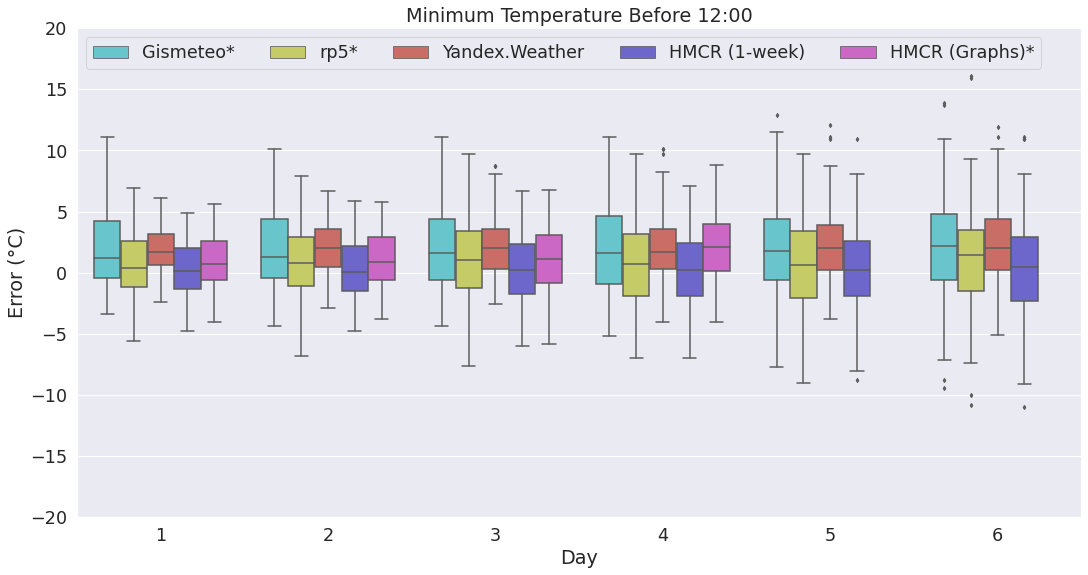

In [30]:
ax = sns.boxplot(x='Day', y='Error (°C)', data=min_temp_plt, hue='Forecast', palette=colors, whis=1.5, fliersize=3)
handles, labels  =  ax.get_legend_handles_labels()
ax.set(title='Minimum Temperature Before 12:00')
ax.set_ylim(-20.0, 20.0)
_ = ax.legend(handles, [legend_labels[k] for k in labels], ncol=5, loc='upper left')

## Maximum Temperature After 12:00

In [31]:
max_temp_plt = max_temp.loc[(max_temp['date'] >= start_date) & (max_temp['date'] <= end_date)].copy()
max_temp_plt['Day'] = np.ceil((max_temp['12h_bin'] - 1) / 2).astype(int)
max_temp_plt = max_temp_plt.loc[max_temp_plt['Day'] <= day_lim]
max_temp_plt = max_temp_plt.melt(id_vars=['Day'],
                                 value_vars=['gismeteo', 'rp5', 'yandex', 'hmcr_w', 'hmcr_g'],
                                 var_name='Forecast',
                                 value_name='Error (°C)')

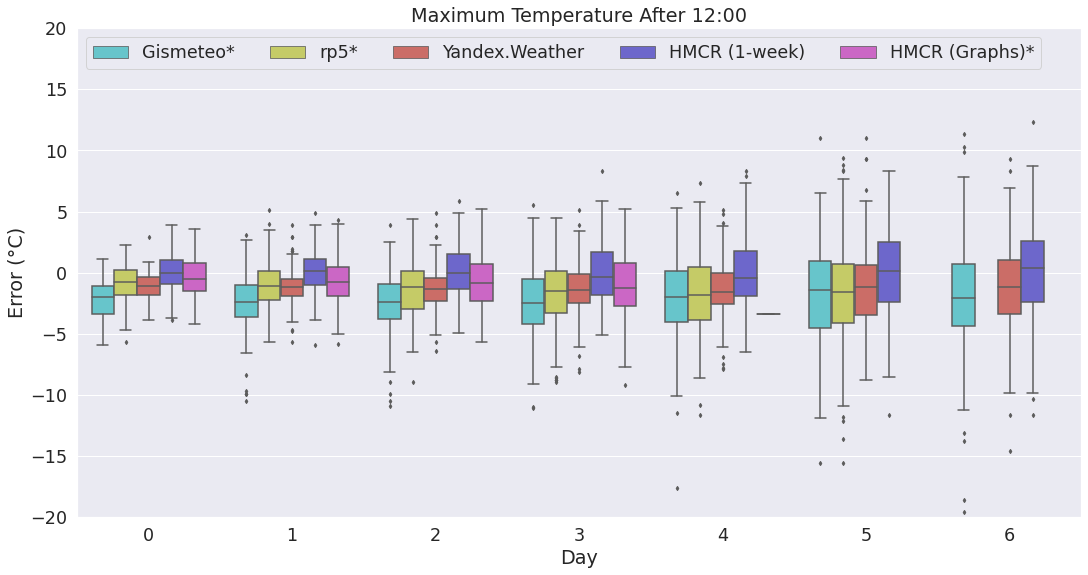

In [32]:
ax = sns.boxplot(x='Day', y='Error (°C)', data=max_temp_plt, hue='Forecast', palette=colors, whis=1.5, fliersize=3)
handles, labels  =  ax.get_legend_handles_labels()
ax.set(title='Maximum Temperature After 12:00')
ax.set_ylim(-20.0, 20.0)
_ = ax.legend(handles, [legend_labels[k] for k in labels], ncol=5, loc='upper left')

## Temperature at 02:00, 05:00, 08:00, 11:00, 14:00, 17:00, 20:00 and 23:00

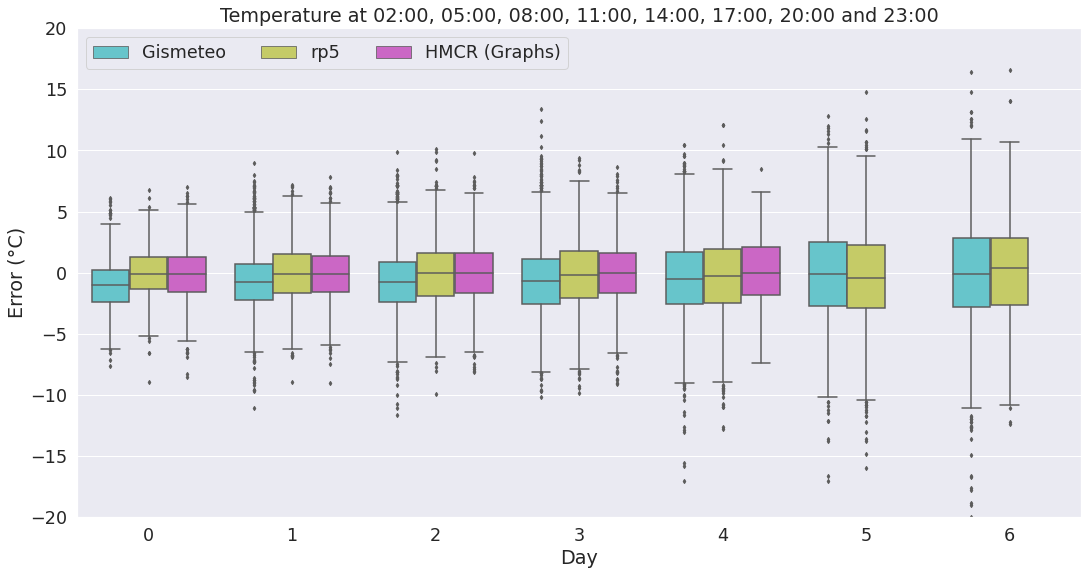

In [33]:
title = 'Temperature at 02:00, 05:00, 08:00, 11:00, 14:00, 17:00, 20:00 and 23:00'
legend_labels = {'gismeteo': 'Gismeteo', 'rp5': 'rp5', 'hmcr_g': 'HMCR (Graphs)'}
boxplot_params(temp_8, title, 'Error (°C)', (-20.0, 20.0), legend_labels)

## Atmospheric Pressure at 02:00, 05:00, 08:00, 11:00, 14:00, 17:00, 20:00 and 23:00

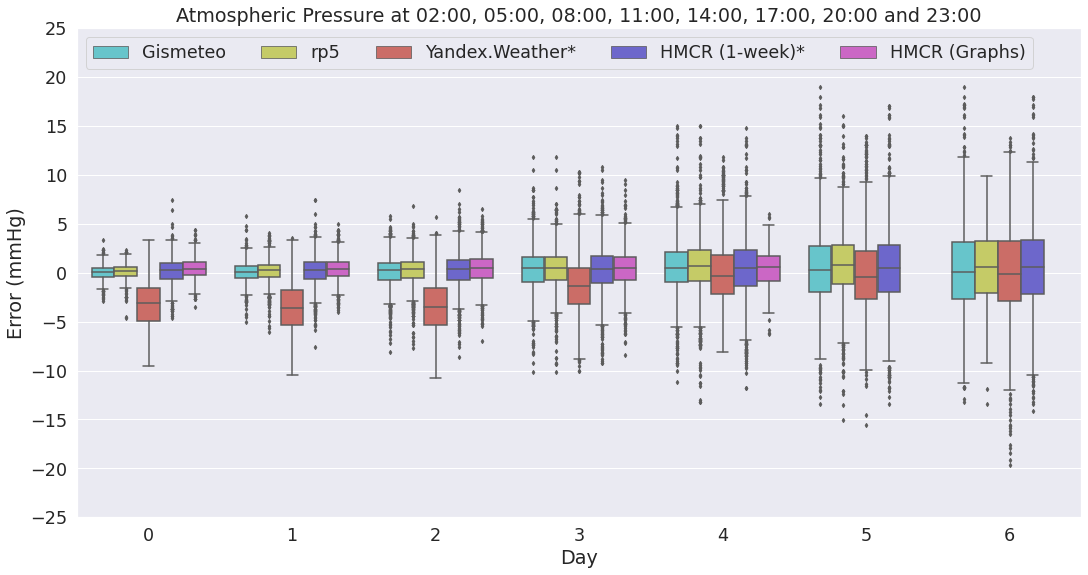

In [34]:
title = 'Atmospheric Pressure at 02:00, 05:00, 08:00, 11:00, 14:00, 17:00, 20:00 and 23:00'
legend_labels = {'gismeteo': 'Gismeteo',
                 'rp5': 'rp5',
                 'yandex': 'Yandex.Weather*',
                 'hmcr_w': 'HMCR (1-week)*',
                 'hmcr_g': 'HMCR (Graphs)'}
boxplot_params(press_8, title, 'Error (mmHg)', (-25.0, 25.0), legend_labels, yticks=(-25, 26, 5))

## Relative Humidity

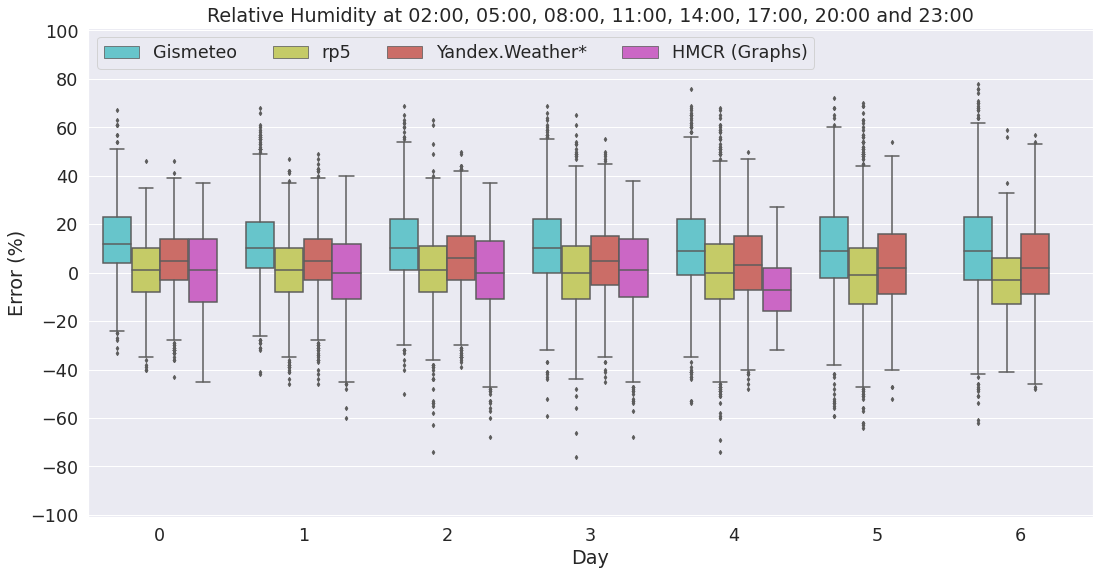

In [35]:
title = 'Relative Humidity at 02:00, 05:00, 08:00, 11:00, 14:00, 17:00, 20:00 and 23:00'
legend_labels = {'gismeteo': 'Gismeteo',
                 'rp5': 'rp5',
                 'yandex': 'Yandex.Weather*',
                 'hmcr_g': 'HMCR (Graphs)'}
boxplot_params(hum_8, title, 'Error (%)', (-101.0, 101.0), legend_labels, yticks=(-100, 101, 20))

## Wind Speed

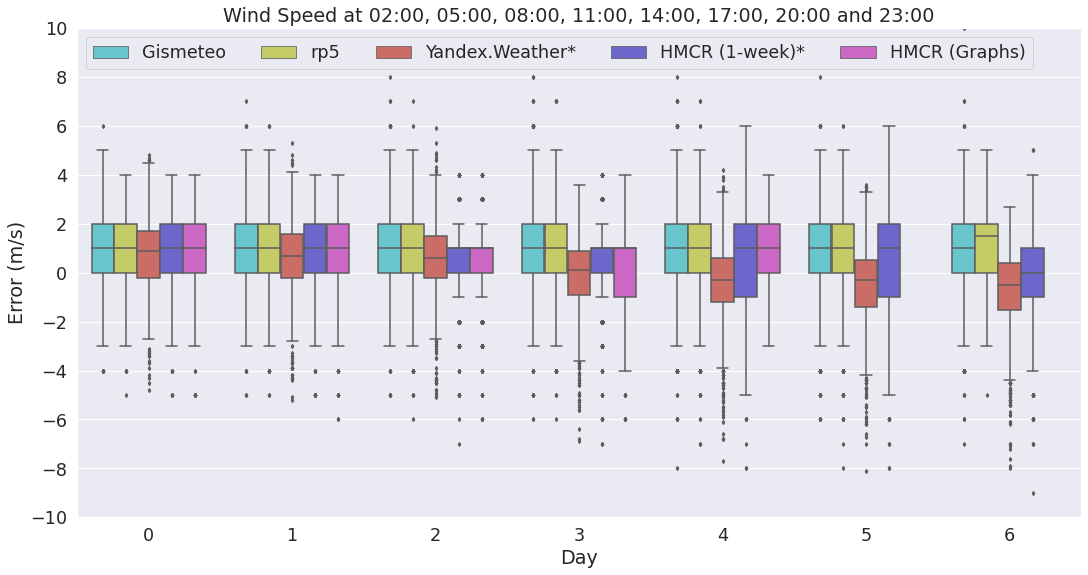

In [36]:
title = 'Wind Speed at 02:00, 05:00, 08:00, 11:00, 14:00, 17:00, 20:00 and 23:00'
legend_labels = {'gismeteo': 'Gismeteo',
                 'rp5': 'rp5',
                 'yandex': 'Yandex.Weather*',
                 'hmcr_w': 'HMCR (1-week)*',
                 'hmcr_g': 'HMCR (Graphs)'}
boxplot_params(wind_speed_8, title, 'Error (m/s)', (-10.0, 10.0), legend_labels, yticks=(-10, 11, 2))

## Wind Direction at 02:00, 05:00, 08:00, 11:00, 14:00, 17:00, 20:00 and 23:00

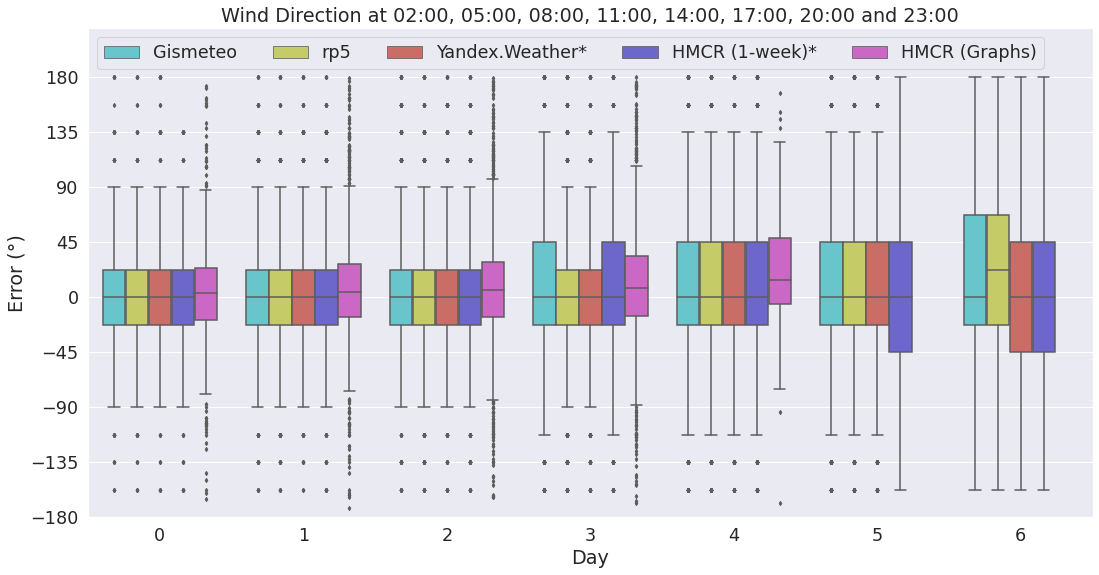

In [37]:
title = 'Wind Direction at 02:00, 05:00, 08:00, 11:00, 14:00, 17:00, 20:00 and 23:00'
legend_labels = {'gismeteo': 'Gismeteo',
                 'rp5': 'rp5',
                 'yandex': 'Yandex.Weather*',
                 'hmcr_w': 'HMCR (1-week)*',
                 'hmcr_g': 'HMCR (Graphs)'}
boxplot_params(wind_dir_8, title, 'Error (°)', (-180, 220), legend_labels, yticks=(-180, 181, 45))

## Precipitation in 12-Hour Intervals

In [38]:
precip_plt = precip.loc[(precip['datetime'] >= start_date) & (precip['datetime'] <= end_date)]
ylabel_precip = 'Error (mm per 12 hours)'
legend_labels = {'gismeteo': 'Gismeteo',
                 'rp5': 'rp5',
                 'hmcr_g': 'HMCR (Graphs)'}

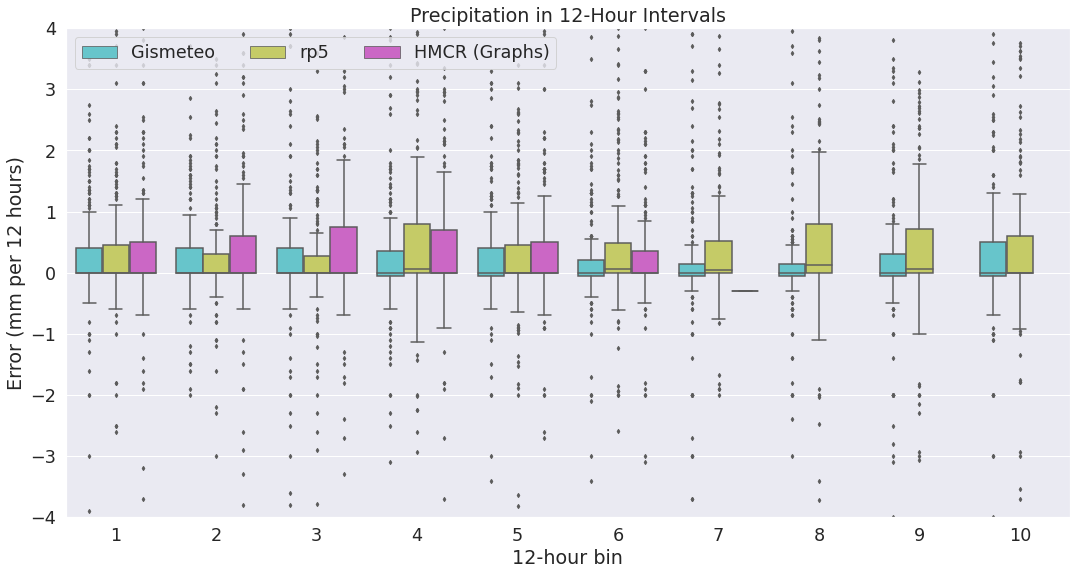

In [39]:
df_ = precip_plt.melt(id_vars=['12h_bin'],
                      value_vars=[*legend_labels.keys()],
                      var_name='Forecast',
                      value_name='Error (mm per 12 hours)')
df_ = df_.loc[df_['12h_bin'] <= 10]
ax = sns.boxplot(x='12h_bin', y='Error (mm per 12 hours)', data=df_, hue='Forecast', palette=colors, whis=1.5, fliersize=3)
handles, labels = ax.get_legend_handles_labels()
ax.set(title='Precipitation in 12-Hour Intervals', xlabel='12-hour bin')
ax.set_ylim(-4, 4)
# ax.set_yticks(range(*yticks))
_ = ax.legend(handles, [legend_labels[k] for k in labels], ncol=3, loc='upper left')

We can define the elements of the confusion matrix as:
* **True Positive (TP)**: forecast value > 0, historical value > 0;
* **False Positive (FP)**: forecast value > 0, historical value = 0;
* **True Negative (TN)**: forecast value = 0, historical value = 0;
* **False Negative (FN)**: forecast value = 0, historical value > 0.

Balanced accuracy ($BA$) is defined as: $$ BA = \frac{TPR + TNR}{2},$$
where $TPR$ is true positive rate (also called recall or sensitivity): 
$$ \text{TPR} = \frac{\sum \text{TP} } {\sum \text{TP} + \sum \text{FN}},$$
and $TNR$ is true negative rate (or specificity):
$$ \text{TNR} = \frac{\sum \text{TN} } {\sum \text{TN} + \sum \text{FP}}.$$

In [40]:
# TPR
precip_tpr = precip_plt.loc[precip_plt['hist'] > 0.0].copy()
for col in ['gismeteo', 'rp5', 'hmcr_g']:
    val = precip_tpr[col] + precip_tpr['hist']
    tp = val > 0.001
    fn = val <= 0.001
    precip_tpr.loc[tp, col] = 1
    precip_tpr.loc[fn, col] = 0
precip_tpr = precip_tpr.groupby('12h_bin').sum() / precip_tpr.groupby('12h_bin').count()
precip_tpr = precip_tpr[['gismeteo', 'rp5', 'hmcr_g']]
# TNR
precip_tnr = precip_plt.loc[precip_plt['hist'] == 0.0].copy()
for col in ['gismeteo', 'rp5', 'hmcr_g']:
    val = precip_tnr[col] + precip_tnr['hist']
    fp = val > 0.001
    tn = val <= 0.001
    precip_tnr.loc[tn, col] = 1
    precip_tnr.loc[fp, col] = 0
precip_tnr = precip_tnr.groupby('12h_bin').sum() / precip_tnr.groupby('12h_bin').count()
precip_tnr = precip_tnr[['gismeteo', 'rp5', 'hmcr_g']]
# BA
precip_ba = (precip_tpr + precip_tnr) / 2

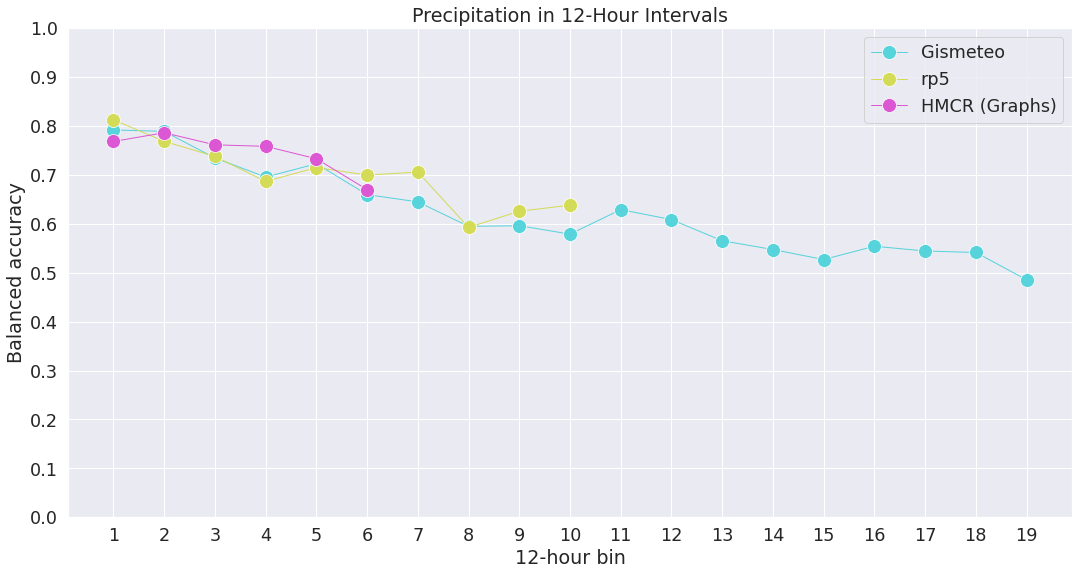

In [41]:
ax = sns.lineplot(data=precip_ba, palette=colors, linewidth=1, marker='o', markersize=14, dashes=False)
ax.set(xlabel='12-hour bin', ylabel='Balanced accuracy', title='Precipitation in 12-Hour Intervals')
ax.set_ylim(0, 1)
ax.set_xticks(list(range(1, 20)))
ax.set_yticks([float(x)/10 for x in range(0, 11)])
_ = ax.legend(labels=['Gismeteo', 'rp5', 'HMCR (Graphs)'])